### Milestone 4: Deep learning, due Wednesday, April 26, 2017

For this milestone you will (finally) use deep learning to predict movie genres. You will train one small network from scratch on the posters only, and compare this one to a pre-trained network that you fine tune. [Here](https://keras.io/getting-started/faq/#how-can-i-use-pre-trained-models-in-keras) is a description of how to use pretrained models in Keras.

You can try different architectures, initializations, parameter settings, optimization methods, etc. Be adventurous and explore deep learning! It can be fun to combine the features learned by the deep learning model with a SVM, or incorporate meta data into your deep learning model. 

**Note:** Be mindful of the longer training times for deep models. Not only for training time, but also for the parameter tuning efforts. You need time to develop a feel for the different parameters and which settings work, which normalization you want to use, which model architecture you choose, etc. 

It is great that we have GPUs via AWS to speed up the actual computation time, but you need to be mindful of your AWS credits. The GPU instances are not cheap and can accumulate costs rather quickly. Think about your model first and do some quick dry runs with a larger learning rate or large batch size on your local machine. 

The notebook to submit this week should at least include:

- Complete description of the deep network you trained from scratch, including parameter settings, performance, features learned, etc. 
- Complete description of the pre-trained network that you fine tuned, including parameter settings, performance, features learned, etc. 
- Discussion of the results, how much improvement you gained with fine tuning, etc. 
- Discussion of at least one additional exploratory idea you pursued

In [1]:
import urllib2
import PIL
import os
import numpy as np

# for image manipulation. Easier to do 
# here than with Keras, as per
# https://piazza.com/class/ivlbdd3nigy3um?cid=818
#!sudo pip install Image
import PIL.Image as Image
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten

Using TensorFlow backend.


## Step One: Extracting Movies From URL 

In [3]:
# train = pd.read_csv("train_full.csv")
# train.drop("Unnamed: 0", axis=1, inplace=True)
# print "Train shape:", train.shape
# train.head(1)

In [4]:
train_thinned = pd.read_csv("train.csv")
train_thinned.drop("Unnamed: 0", axis=1, inplace=True)
print "train_thinned shape:", train_thinned.shape
train_thinned.head(1)

train_thinned shape: (540, 29)


,10402,10749,10751,10752,12,14,16,18,27,28,...,lead actors,movie_id,overview,popularity,poster_path,release_date,title,video,vote_average,vote_count
0,0,0,1,0,0,0,1,0,0,0,...,"[u'Alec Baldwin', u'Miles Bakshi', u'Jimmy Kim...",295693,A story about how a new baby's arrival impacts...,305.881041,/unPB1iyEeTBcKiLg8W083rlViFH.jpg,2017-03-23,The Boss Baby,False,5.7,510


## Important. 

The line below aliases the DF that we want to work with as `curr_df`. When we decide later on to use the full training set instead of just `train_thinned`, all we need to do is set it in the cell below and re-run the code. This will prevent us from having to find/replace all instances of the past dataframe.

In [5]:
curr_df = train_thinned

In [6]:
## Helper that downloads web images 
## Takes in the poster path and the id of the movie 
## Saves the movie as a jpg as the unique id of the movie 
## In the images folder.
def download_web_image(poster_path, movie_id):
    # given that we're going to resize our images to be 32x32
    # or something else really small, let's download really small images 
    # to start
    base_url = "https://image.tmdb.org/t/p/w92/" 
    
    request = urllib2.Request(base_url + poster_path)
    img = urllib2.urlopen(request).read()
    image_name= "images/" + str(movie_id) + ".jpg"
    
    with open(image_name, 'w') as f: 
        f.write(img)

In [7]:
### iterate through all of the images in the thinned dataset, saving locally 
if 1:
    print "If you actually want to download posters, you'll need to turn the `1` above into a `0`. This code doesn't run by default in the notebook so that you don't accidentally download hundreds of images."
else:
    for index, row in curr_df.iterrows():
        movie_id = row["movie_id"]
        poster_path = row["poster_path"] 
#         download_web_image(poster_path, movie_id)

If you actually want to download posters, you'll need to turn the `1` above into a `0`. This code doesn't run by default in the notebook so that you don't accidentally download hundreds of images.


In [8]:
img_rows, img_cols = 32, 32

# convert each normal poster to a 32x32 grayscale poster
for img_name in os.listdir("images/"):
    ## This line added to avoid hidden files on mac (Stephen)
    if not img_name.startswith('.'):
        # read in an image and convert to greyscale
        im = Image.open("images/" + img_name).convert("L")
        out = im.resize((img_rows, img_cols))
        out.save("nn_ready_images/" + img_name)

# GRADER: IGNORE THIS PART

Simply used for data management) 



### Data Wrangling

In [9]:
# number of labels in our output
n_labels = 17

In [10]:
# now we need training and testing data. in the current state,
# we have a bunch of greyscale images named by their movie ids.
# to get the data, we can first just split all the movie ids (X) in the
# dataframe intro train and test sets, and then grab their multilabel
# matrices (y)
m_ids = curr_df.movie_id.values

# shuffle the ids to get a random sample
np.random.shuffle(m_ids)

import math
train_size = int(math.floor(.7 * len(m_ids)))

# get the movie_ids (each of which has an image in "nn_images_ready/"
# which is ready to be put through the neural net
train_ids = m_ids[:train_size]
test_ids = m_ids[train_size:]

In [11]:
# these are the column names of the multilabel matrix
label_names = curr_df.columns[:n_labels]

y_train = np.array([curr_df[curr_df.movie_id == movie_id][label_names].values[0] for movie_id in train_ids])
y_test  = np.array([curr_df[curr_df.movie_id == movie_id][label_names].values[0] for movie_id in test_ids])

# should be (num_samples, num_labels)
print "y_train shape:", y_train.shape
print "y_test shape:", y_test.shape

y_train shape: (378, 17)
y_test shape: (162, 17)


In [12]:
# smaller batch size means noisier gradient, but more updates per epoch
batch_size = 512

# number of iterations over the complete training data
epochs = 15

In [13]:
# load image matrices into memory
x_train = np.array([np.asarray(Image.open("nn_ready_images/" + str(m_id) + ".jpg")) for m_id in train_ids])
x_test =  np.array([np.asarray(Image.open("nn_ready_images/" + str(m_id) + ".jpg")) for m_id in test_ids])

In [14]:
# output should be (num_images, img_height, img_width)
print "x_train shape:", x_train.shape
print "x_test shape:", x_test.shape

x_train shape: (378, 32, 32)
x_test shape: (162, 32, 32)


In [15]:
# code borrowed from Keras_CNN lab

# now we need to reshape x_train and x_test so that they work with CNNs
# Following the example in "labs/Keras_CNN.ipynb", this needs to be an array 
# of images with shape determined by the backend, including the depth dimension,
# which is 1 for greyscale

# x_train is of shape n_samples x 32 x 32
# for a CNN we want to keep the image shape
# need to explicitly tell keras that it is a gray value image
# so each image is 32x32x1 not 32x32x3
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
# normalize image values to [0,1]
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print "x_train shape:", x_train.shape
print x_train.shape[0], "train samples"
print x_test.shape[0], "test samples"

x_train shape: (378, 32, 32, 1)
378 train samples
162 test samples


### Model Architecture

In [16]:
# create an empty network model
model = Sequential()

# define the input layer to the CNN
# input shape is a tuple of the # rows, # cols, and # channels (1 for grayscale)
# the first parameter to Conv2D is the number of filters we want to convolve
# over the input images
model.add(Conv2D(16, kernel_size=(5, 5), activation='relu', input_shape=input_shape))

# create a max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# add another convolution layer
# we could double the number of filters as max pool made the 
# feature maps much smaller, but we're not doing this to improve runtime
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))

# create a max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# ================

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))

# create a max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# ================

# flatten for fully connected classification layer
model.add(Flatten())

# note that the 10 is the number of classes we have
# the classes are mutually exclusive so softmax is a good choice
# --- fully connected layer ---
model.add(Dense(64, activation='relu'))

# recommended by: https://github.com/fchollet/keras/issues/761
# uses a sigmoid activation rather than softmax, which apparently
# gives us a label vector back
model.add(Dense(n_labels, activation='sigmoid'))

# prints out a summary of the model architecture
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
__________

### Compile the model

Let's use a large learning rate (0.1) while we're working locally

### Train the model

# LOOKING AT THIS NOTEBOOK FROM HERE 



# Fine tuning a pre-trained model (Part Two)

In [21]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

### What is our baseline? 
To begin it's important to know what does "good" even mean in a model? In order to do this, we needed a baseline accuracy that we thought would be a good benchmark to beat. For this multilabel classification problem, we face an extremely sparse matrix. Most movies are only in a few of the many categorie. As a result, when we are trying to see how good we are doing, we should compare to a simple baseline of all zeros. This is shown below. 

In [86]:
accuracy_list = [] 
for y in y_test: 
    for x in y:
        accuracy_list.append(x == 0)
    
print "This is our baseline accuracy", np.mean(accuracy_list)

This is our baseline accuracy 0.829339143065


## Choosing a pretrained model: 
For this task, we needed a pretrained model that would be able to give us a reasonable pretrained network. As well ,we wanted a model that would be able to handle multilabel classification.

One of the best current models for this is InceptionV3. InceptionV3 is trained on the huge corpus of images called ImageNet. It takes in 299x299 RGB images and uses its pretraining in order to make multilabel classification.


### Convert Images to Format for InceptionV3 

In [87]:
### Because inception takes in a 299 x 299 RGB image, we need to download them as such 
img_rows, img_cols = 299, 299

# convert each normal poster to a 299x299 poster
for img_name in os.listdir("images/"):
    if not img_name.startswith('.'):
        # read in an image, do not convert to greyscale 
        im = Image.open("images/" + img_name)
        out = im.resize((img_rows, img_cols))
        ## save to the inception images folder 
        out.save("inception_ready_images/" + img_name)

In [88]:
# load image matrices into memory
x_train = np.array([np.asarray(Image.open("inception_ready_images/" + str(m_id) + ".jpg")) for m_id in train_ids])
x_test =  np.array([np.asarray(Image.open("inception_ready_images/" + str(m_id) + ".jpg")) for m_id in test_ids])

In [89]:
# create the base pre-trained model
base_model = InceptionV3(weights= 'imagenet', include_top=False)

In [90]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(n_labels, activation='softmax')(x)

In [91]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=["accuracy"])


In [31]:
## http://stackoverflow.com/questions/40574386/keras-model-fit-generator 
## This, in theory should generate the data in a way that we want. 
datagen = ImageDataGenerator()
datagen.fit(x_train)

In [93]:
### Check out the validation set on this 
### SHOULD BE CHANGED TO VALIDATION SET 
model.fit_generator(datagen.flow(x_train, y_train, batch_size = 1), steps_per_epoch = 10, epochs = 3, validation_data=(x_test, y_test))




Epoch 1/3
10/10 [==============================] - 12s - loss: 3.9738 - acc: 0.7529 - val_loss: 3.2244 - val_acc: 0.7988
Epoch 2/3
10/10 [==============================] - 12s - loss: 2.9319 - acc: 0.8176 - val_loss: 3.2188 - val_acc: 0.7988

In [137]:
model_1 = model.fit(x_train, y_train, epochs = 10, validation_split = .3)

Train on 264 samples, validate on 114 samples
Epoch 1/10
264/264 [==============================] - 6s - loss: 0.2742 - acc: 0.8471 - val_loss: 0.6526 - val_acc: 0.8318
Epoch 2/10
264/264 [==============================] - 6s - loss: 0.2644 - acc: 0.8469 - val_loss: 0.6348 - val_acc: 0.8323

In [101]:
#model.evaluate(x_test, y_test)
predictions = model.predict(x_test)


162

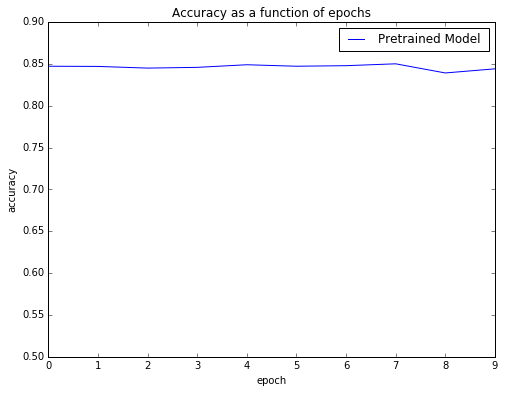

In [139]:
# training slows down
plt.figure(figsize=(8, 6))
plt.plot(model_1.history['acc'], label = "Pretrained Model ")
plt.title("Accuracy as a function of epochs")
plt.legend()
#plt.subtitle("Note how the number of epochs effects our prefit model LESS than our other model")
plt.ylim([.5,.9])
plt.xlabel("epoch")
plt.ylabel("accuracy")

## Why is the pretrained model not changing? 

At first glance, it seems like our training of just the final layer is not doing much at all. This could be because with 312 different layers, our final layer is not effecting how we are predicting our data groups very well at all. One way that we'll look to address this is by going into our pretrained neural network and trying to train more layers. We have this approah below. 

In [110]:
np.unique(np.round(predictions), return_counts = True) 

(array([ 0.], dtype=float32), array([2754]))

## Training Last Two Layers of Pretuned Model 
In this next section, we trained the final layers of the pretuned model. This is for a number of reasons. First it is much faster to only tune a few layers of a model than the entire model. Two, we believe that some of the underlying characteristics of images that are discovered in the InceptionV3 model will be very useful for us in classifying movie images. So, we do not want to remove those pretrained weights. 

In [111]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)


(0, 'input_2')
(1, 'conv2d_98')
(2, 'batch_normalization_95')
(3, 'activation_95')
(4, 'conv2d_99')
(5, 'batch_normalization_96')
(6, 'activation_96')
(7, 'conv2d_100')
(8, 'batch_normalization_97')
(9, 'activation_97')
(10, 'max_pooling2d_8')
(11, 'conv2d_101')
(12, 'batch_normalization_98')
(13, 'activation_98')
(14, 'conv2d_102')
(15, 'batch_normalization_99')
(16, 'activation_99')
(17, 'max_pooling2d_9')
(18, 'conv2d_106')
(19, 'batch_normalization_103')
(20, 'activation_103')
(21, 'conv2d_104')
(22, 'conv2d_107')
(23, 'batch_normalization_101')
(24, 'batch_normalization_104')
(25, 'activation_101')
(26, 'activation_104')
(27, 'average_pooling2d_10')
(28, 'conv2d_103')
(29, 'conv2d_105')
(30, 'conv2d_108')
(31, 'conv2d_109')
(32, 'batch_normalization_100')
(33, 'batch_normalization_102')
(34, 'batch_normalization_105')
(35, 'batch_normalization_106')
(36, 'activation_100')
(37, 'activation_102')
(38, 'activation_105')
(39, 'activation_106')
(40, 'mixed0')
(41, 'conv2d_113')
(42, 'b

### In total we have 310 layers prebuilt, we'll freeze everything but the last 2 in order to do our finetuning. 

In [112]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 172 layers and unfreeze the rest:
for layer in model.layers[:308]:
   layer.trainable = False
for layer in model.layers[308:]:
   layer.trainable = True

In [124]:
# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD


### Lr is the learning rate, this is set currently to be relatively low 
### however, if we wanted to learn more quickly on each update we would increase this 
### THIS IS SOMETHING THAT WE CAN TEST 
## The other thing that we can check out is momentum , momentum is how much 
### the model continues to learn in the same direction. This is another model that we could check to see how 
## important it is via cross validation potentially. 
## Explanation is here http://sebastianruder.com/optimizing-gradient-descent/index.html#momentum 
model.compile(optimizer=SGD(lr=0.2, momentum=0.9), loss='binary_crossentropy', metrics = ["accuracy"])



In [128]:
# history_prefit = model.fit_generator(datagen.flow(x_train, y_train, batch_size = 1), steps_per_epoch = 5, epochs = 15,validation_data=(x_test, y_test))
history_prefit = model.fit(x_train, y_train, epochs = 15, validation_split = .3)



Train on 264 samples, validate on 114 samples
Epoch 1/50
264/264 [==============================] - 6s - loss: 0.3498 - acc: 0.8369 - val_loss: 0.6051 - val_acc: 0.8292
Epoch 2/50
264/264 [==============================] - 6s - loss: 0.3513 - acc: 0.8342 - val_loss: 0.5717 - val_acc: 0.8338

In [129]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

('Test loss:', 0.64645802018083176)
('Test accuracy:', 0.82861292950900989)


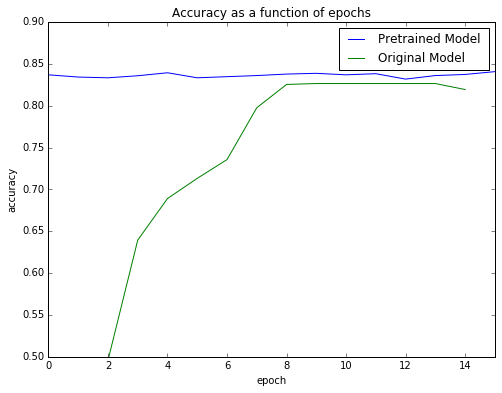

In [134]:
# here is a visualization of the training process
# typically we gain a lot in the beginning and then
# training slows down
plt.figure(figsize=(8, 6))
plt.plot(history_prefit.history['acc'], label = "Pretrained Model ")
plt.plot(history.history['acc'], label = "Handmade Model")
plt.title("Accuracy as a function of epochs")
plt.legend()
#plt.subtitle("Note how the number of epochs effects our prefit model LESS than our other model")
plt.ylim([.5,.9])
plt.xlim([0,15])
plt.xlabel("epoch")
plt.ylabel("accuracy")

## Pretrained Model Changes Less Between Epochs
This is interesting, it appears that our pretrained model changes significantly less between epochs than our purely new model. This makes sense - the inceptionv3 model took a few weeks to train in total. 

Looking at the model, we might even ask: is our pretrained model changing at all? As we'll see in the below graph it is - but very slowly. 

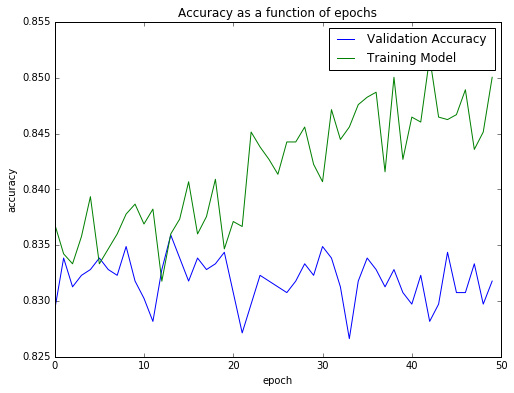

In [136]:
# here is a visualization of the training process
# typically we gain a lot in the beginning and then
# training slows down
plt.figure(figsize=(8, 6))
plt.plot(history_prefit.history['val_acc'], label = "Validation Accuracy ")
plt.plot(history_prefit.history['acc'], label = "Training Accuracy")
plt.title("Accuracy as a function of epochs")
plt.legend()
#plt.subtitle("Note how the number of epochs effects our prefit model LESS than our other model")
plt.xlabel("epoch")
plt.ylabel("accuracy")

## Slight Overfitting Overtime
IN the above graph we can see two things. The first is that it seems that epochs do not seems to have nearly as much influence on our pretrained model as they do in our self-generated model. 

The second interesting point is that we are getting graphs that are slowly diverging. It appears that our validation data is getting slightly worse overtime and our training accuracy is getting better. Likely, this would change more 

## Tuning Parameters in the Final Two Layers: 
Let's check out some other parameters to tune to see how they affect our pretrained neural network. 


## Tuning  Number of Layers: 

In [78]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 172 layers and unfreeze the rest:
for layer in model.layers[:172]:
   layer.trainable = False
for layer in model.layers[172:]:
   layer.trainable = True

## Tuning the learning rate 

It could be that in or model the learning rate significantly affects how well we can learn or new model. We'll try out a few different learning rates and see how they change our predictions 

In [148]:
### Lr is the learning rate, this is set currently to be relatively low 
### however, if we wanted to learn more quickly on each update we would increase this 
### THIS IS SOMETHING THAT WE CAN TEST 
## The other thing that we can check out is momentum , momentum is how much 
### the model continues to learn in the same direction. This is another model that we could check to see how 
## important it is via cross validation potentially. 
## Explanation is here http://sebastianruder.com/optimizing-gradient-descent/index.html#momentum 

model_list =[] 
learning_rates = [.01, .1, .5, .9]
for lr in learning_rates: 
    model.compile(optimizer=SGD(lr=lr, momentum=0.9), loss='binary_crossentropy', metrics = ["accuracy"])

    # history_prefit = model.fit_generator(datagen.flow(x_train, y_train, batch_size = 1), steps_per_epoch = 5, epochs = 15,validation_data=(x_test, y_test))
    model_list.append(model.fit(x_train, y_train, epochs = 50, validation_data=(x_test, y_test)))


Train on 378 samples, validate on 162 samples
Epoch 1/50
378/378 [==============================] - 10s - loss: 0.4921 - acc: 0.8350 - val_loss: 0.5763 - val_acc: 0.8301

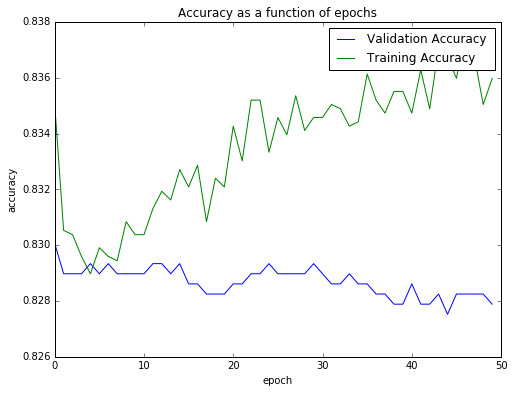

In [149]:
plt.figure(figsize=(8, 6))
plt.plot(model_list[0].history['val_acc'], label = "Validation Accuracy ")
plt.plot(model_list[0].history['acc'], label = "Training Accuracy")
plt.title("Accuracy for training rate of .01")
plt.legend()
#plt.subtitle("Note how the number of epochs effects our prefit model LESS than our other model")
plt.xlabel("epoch")
plt.ylabel("accuracy")


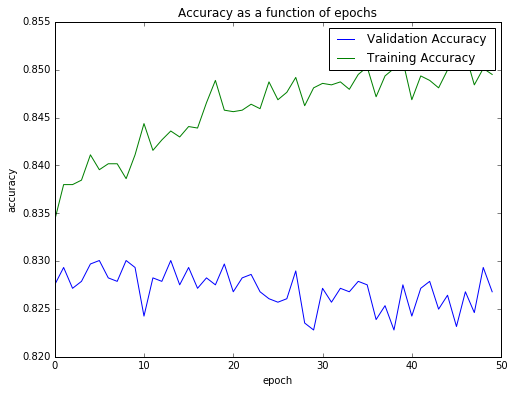

In [150]:
plt.figure(figsize=(8, 6))
plt.plot(model_list[1].history['val_acc'], label = "Validation Accuracy ")
plt.plot(model_list[1].history['acc'], label = "Training Accuracy")
plt.title("Accuracy for a training rate of .1")
plt.legend()
#plt.subtitle("Note how the number of epochs effects our prefit model LESS than our other model")
plt.xlabel("epoch")
plt.ylabel("accuracy")

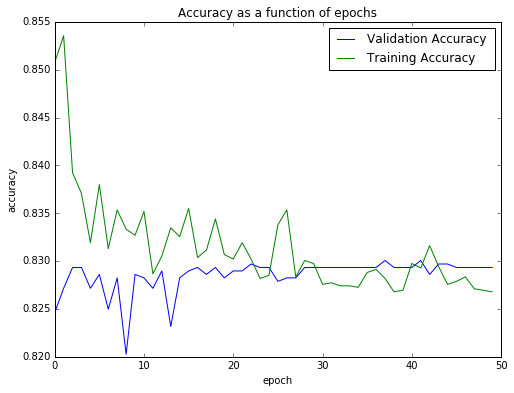

In [151]:
plt.figure(figsize=(8, 6))
plt.plot(model_list[2].history['val_acc'], label = "Validation Accuracy ")
plt.plot(model_list[2].history['acc'], label = "Training Accuracy")
plt.title("Accuracy for a training rate of .4")
plt.legend()
#plt.subtitle("Note how the number of epochs effects our prefit model LESS than our other model")
plt.xlabel("epoch")
plt.ylabel("accuracy")

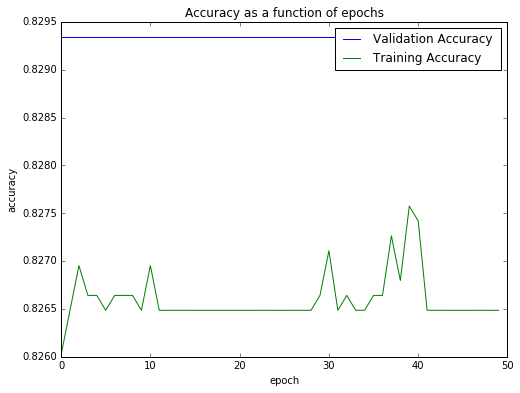

In [152]:
plt.figure(figsize=(8, 6))
plt.plot(model_list[3].history['val_acc'], label = "Validation Accuracy ")
plt.plot(model_list[3].history['acc'], label = "Training Accuracy")
plt.title("Accuracy for a training rate of .9")
plt.legend()
#plt.subtitle("Note how the number of epochs effects our prefit model LESS than our other model")
plt.xlabel("epoch")
plt.ylabel("accuracy")

## Training Rate = Overfitting? 
As we play around with our training rate we found a couple of things. The first is that for a certain range of training rates (somewhere less than .4 and likely around .01 or less) we slowly get overfitting. Again, this takes a *very long time* because we are trying to refit a model that already has 312 layers. 

We also learned that some learning rates just outright fail. It appears that a training rate of .4 and above don't seem to do anything for us when training on the training data OR on the test data. 

Over all, it seems that the training rate does not have too large of an affect on our test accuracy. So, we were not able to improve our end predictions. 

## Changing Momentum 
In this segment, we look at what momentum might do to our predcition. Again for reference momentum refers to how likely stochastic gradient descent is going to continue optimizing along the previous path it was. Often time stochastic gradient descent will move into local maxima, so this is one way for SGD to avoid this. 

In [154]:

model_list_momentum =[] 
momentum_list = [.7, .9, .99]
for m in momentum_list: 
    model.compile(optimizer=SGD(lr=.1, momentum=m), loss='binary_crossentropy', metrics = ["accuracy"])

    # history_prefit = model.fit_generator(datagen.flow(x_train, y_train, batch_size = 1), steps_per_epoch = 5, epochs = 15,validation_data=(x_test, y_test))
    model_list_momentum.append(model.fit(x_train, y_train, epochs = 10, validation_data=(x_test, y_test)))


Train on 378 samples, validate on 162 samples
Epoch 1/10
378/378 [==============================] - 10s - loss: 0.4802 - acc: 0.8265 - val_loss: 0.4868 - val_acc: 0.8293

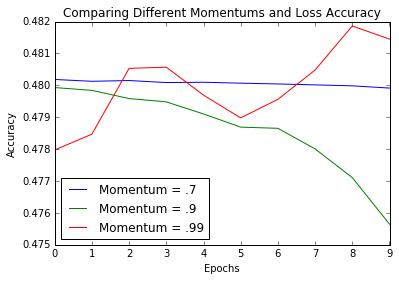

In [157]:
plt.plot(model_list_momentum[0].history["loss"], label = "Momentum = .7")
plt.plot(model_list_momentum[1].history["loss"], label = "Momentum = .9")
plt.plot(model_list_momentum[2].history["loss"], label = "Momentum = .99")
plt.legend(loc = "lower left")
plt.title("Comparing Different Momentums and Loss Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Binary Cross Entropy")


Overall it appears that momentum does not significantly affect how well we predict. However, it does appear that our base level of momentum of around .9 (which is recommended as standard for CNN) seemed to do the best. We can see this because our momentum for .9 seems to be decreasing overtime where our other two do not. Nonetheless it seems overall that the momentum is not a hugely important factor for training a useful pretrained model. 

# 3. Discussion of the results, how much improvement you gained with fine tuning, etc. 

After additional fine tuning, we found that it was very difficult to beat the baseline pretrained model that we created. 

In total we attempted to do thre things to try to improve our pretrained model: change the number of epochs we learn for, change the learning rate in our stochastic gradient secent, and change the momentum of our stochastic gradient descent. Unfortunately, we didn't find that any of these models significantly improved our predictions. 


## Difference Between Pretrained and Untrained
What we did find of interest, however, is how different training our pretrained model and our untrained model was. In many visualizations, we found that the effect of an epoch of training was **significantly** more important for our untrained model than our trained model. 

In fact, it took us a long time to even learn that our pretrained doing was doing any learning at all. In order to save time, we tried tuning on only 15 epochs. However, as we found, the pretrained model barely changes over the course of this time! In order to really effect our pretrained model, we need to do analysis in epochs for a very long-time. This was a very time intensive process. 


## Time as a Resource: Neural Networks 
One of the other big takeaways that we had as a group was the importance of time management, particularly for neural networks. For many of our larger nets with thousands of pictures, our neural nets could take a significant amount of time. 

Interestingly, we found that using the pretrained model often took longer than our own premade model. We had assumed that the main advantage of using a pretrained model would be that it was faster. However, as we discovered this is the case if you want to train a model on a large picture/data corpus. However, if you want to make predictions on only a few thousand data points, a pretrained model might take longer. We hypothesize that this length may occur because the pretrained model has a significant number of layers. InceptionV3, for example, has 312 layers while our best model had between 5-10 layers. 

# 4. Discussion of at least one additional exploratory idea you pursued 
In this section, we might want to add in other features/other ideas etc.